### SI650 HW2: Answer to all problems 

In [1]:
from document_preprocessor import SplitTokenizer, RegexTokenizer, SpaCyTokenizer
from indexing import BasicInvertedIndex
from l2r import L2RRanker, L2RFeatureExtractor
import relevance
from ranker import Ranker
from ranker import BM25
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
from network_features import NetworkFeatures
import pandas as pd

#### Problem 1. (5 points) 

Calculate the set of categories that occur in at least 1000 articles (these are in the category field of each json object). Save these categories to a file.

In [2]:
import random
random.seed(0)
wiki_cat = set()
unique_random_numbers = random.sample(range(0, 200000), 2000)  
thousand_wiki_num = set(list(unique_random_numbers))
with open('./data/wikipedia_200k_dataset.jsonl') as f:
    for i, line in tqdm(enumerate(f)):
        cats = json.loads(line)['categories']
        if i in thousand_wiki_num:
            for cat in cats:
                wiki_cat.add(cat)
            
# save the categories as json file, {id: category}
wiki_categories = {}
with open('./data/wiki_categories.json', 'w') as f:
    for i, cat in tqdm(enumerate(wiki_cat)):
        wiki_categories[i] = cat
    json.dump(wiki_categories, f, indent=4)

200000it [00:08, 22855.06it/s]
7516it [00:00, 2266474.14it/s]


In [3]:
print('Number of categories:', len(wiki_cat))

Number of categories: 7516


#### Problem 2. (5 points) 

Add at least one new feature to be used with your L2R model. The features could be dynamic or static. The feature should not be something you already implemented as a scorer in Homework 1. For some inspiration, think of all the query document relevance ratings you did for Homework 1. What kinds of documents would you want to retrieve or what made them seem more relevant? In a few sentences, describe what your feature is and what your motivation/inspiration was for creating it。

`Answer`: The additional feature calculate the `term cover rate` of query with respect to given document: the motivation behind is that the document we want to retrieve should cover the meaning or words for most part of given query instead of focusing on specific word.

#### Problem 3. (5 points) 

What are the 10 articles with the highest values for PageRank, HITS hub, and HITS authority? Report all three top-10 lists in a table. In a few sentences describe what you see and whether you are surprised to see any articles in these top 10 lists. In another sentence, describe which of the three scores you think would be most useful as a feature for prioritizing “good” documents.

In [13]:
nf = NetworkFeatures()
edge_list_csr_matrix = nf.load_network('./data/edgelist.csv.gz', 92650947)
df = nf.get_all_network_statistics(edge_list_csr_matrix)

In [14]:
df.shape, df.to_csv('./data/network_stats.csv', index=False)

(999841, 4)

Top 10 Articles:

In [4]:
docid_to_title = {} 
with open('./data/wikipedia_200k_dataset.jsonl') as f:
    for i, line in tqdm(enumerate(f)):
        doc = json.loads(line)
        docid_to_title[doc['docid']] = doc['title']
df = pd.read_csv('./data/network_statistics.csv')

200000it [00:08, 23373.29it/s]


In [17]:
# respectively get top 10 docid with respect to pagerank, hub_score, authority_score
top_pagerank = df.sort_values(by='pagerank', ascending=False).head(10)
top_hub_scores = df.sort_values(by='hub_score', ascending=False).head(10)
top_authority_scores = df.sort_values(by='authority_score', ascending=False).head(10)

print('Top 10 docid with respect to pagerank:')
entities = []
for docid in top_pagerank.docid:
    try:
        entities.append(docid_to_title[docid])
    except:
        print('docid:', docid, 'not found in docid_to_title')
print(entities)
    
print('\nTop 10 docid with respect to hub_score:')
entities = []
for docid in top_hub_scores.docid:
    try:
        entities.append(docid_to_title[docid])
    except:
        print('docid:', docid, 'not found in docid_to_title')
print(entities)
    
print('\nTop 10 docid with respect to authority_score:')
entities = []
for docid in top_authority_scores.docid:
    try:
        entities.append(docid_to_title[docid])
    except:
        print('docid:', docid, 'not found in docid_to_title')
print(entities)

Top 10 docid with respect to pagerank:
['Wayback Machine', 'Geographic coordinate system', 'United States', 'The New York Times', 'World War II', 'United Kingdom', 'New York City', 'India', 'France', 'The Guardian']

Top 10 docid with respect to hub_score:
docid: 40250996 not found in docid_to_title
['War on terror', 'Beijing', 'Demonym', 'Joe Biden', 'Foreign relations of the United States', 'Foreign relations of Canada', 'France', 'LGBT rights by country or territory', 'Visa requirements for United States citizens']

Top 10 docid with respect to authority_score:
['Wayback Machine', 'United States', 'France', 'United Kingdom', 'Germany', 'Italy', 'Record label', 'Geographic coordinate system', 'Record producer', 'Spain']


`In the top 10 lists for PageRank, hub score, and authority score, many of the documents are well-known entities like "United States," "France," "United Kingdom," and "The New York Times," which are unsurprisingly central to a wide range of topics. It’s interesting to see documents like "Wayback Machine" and "Geographic coordinate system" consistently ranking high across multiple metrics, indicating their broad importance in linking information. The hub score includes some unexpected entries like "Joe Biden" and "War on terror," which suggests these topics are influential sources of information but may not be as authoritative as more general documents.`

`Of the three scores, PageRank seems the most useful for prioritizing "good" documents, as it reflects both the importance and the connectedness of a document within the broader network.`

#### Problem 4 (5 points)

Plot article length (in terms of tokens as measured by split()) versus PageRank using the values for the first 10K documents (calculate PageRank for the whole network first). In a few sentences, describe what you see and how you interpret the relationship between the two measures.

In [18]:
doc_length = []
doc_pagerank = []
with open('./data/wikipedia_200k_dataset.jsonl') as f:
    for i, line in tqdm(enumerate(f)):
        if i == 10000:
            break
        doc = json.loads(line)
        if doc['docid'] in df.docid.values:
            doc_length.append(len(doc['text']))
            doc_pagerank.append(df[df.docid == doc['docid']].pagerank.values[0])

10000it [00:10, 916.20it/s]


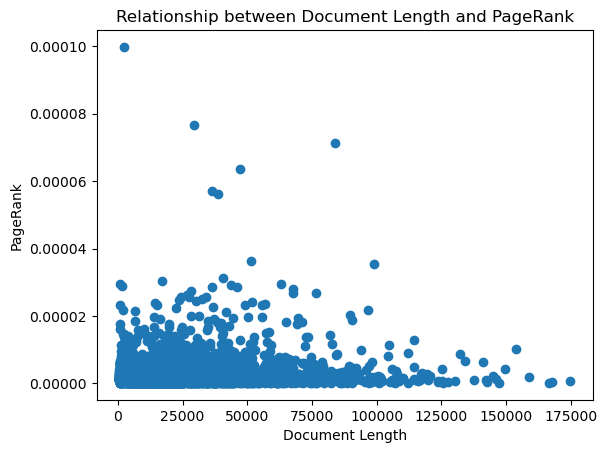

In [19]:
# plot the relationship between doc_length and pagerank
plt.scatter(doc_length, doc_pagerank)
plt.xlabel('Document Length')
plt.ylabel('PageRank')
plt.title('Relationship between Document Length and PageRank')
plt.show()

`No Strong Correlation Between Document Length and PageRank: From the scatter plot, there doesn't seem to be a clear correlation between document length and PageRank. Both short and long documents can have low or high PageRank, indicating that document length does not directly influence a document's importance or centrality in the network.`

#### Problem 5. (5 points) 

Which features does the model care about? Once you have finished training your model, let’s take a look by examining the feature importance scores in the model. Make a plot using the feature importances field of the LightGBM model and show its value for each of the features except the binary has-category features (this should
result in far fewer). Be sure to label the features by name (you should know which features are in which order based on how you construct the feature vector). In a few sentences, describe what you see in the plot in terms of which features are most useful. Do any surprise you?

In [4]:
wiki_path = './data/wikipedia_200k_dataset.jsonl'
wiki_title_dir = 'wiki_title_dir'
wiki_text_dir = 'wiki_text_dir'
stopwords_path = './data/stopwords.txt'

stopwords_set = set()
with open(stopwords_path, 'r') as f:
    for line in tqdm(f):
        stopwords_set.add(line.strip())

544it [00:00, ?it/s]


In [3]:
# index = Indexer.create_index(IndexType.BasicInvertedIndex, 
#                              wiki_path, RegexTokenizer('\w+'), stopwords=stopwords_set, 
#                              minimum_word_frequency=1, text_key='title')
# index.save('./wiki_title_dir')

200000it [00:10, 19418.11it/s]
100%|██████████| 200000/200000 [00:01<00:00, 111098.24it/s]


Complete saving index!


In [3]:
# index = Indexer.create_index(IndexType.BasicInvertedIndex, 
#                              wiki_path, RegexTokenizer('\w+'), stopwords=stopwords_set, 
#                              minimum_word_frequency=50, text_key='text')
# index.save('./wiki_text_dir')

200000it [10:09, 328.37it/s] 
100%|██████████| 200000/200000 [20:13<00:00, 164.83it/s]  


Complete saving index!


- Initialize doc and title index

In [5]:
title_index = BasicInvertedIndex()
title_index.load('./wiki_title_dir')

Complete loading index!


In [6]:
doc_index = BasicInvertedIndex()
doc_index.load('./wiki_text_dir')

Complete loading index!


- Prepare and Train the model 

In [7]:
# recognize the categories: set[str]
recognized_categories = set()   

with open('./data/wiki_categories.json', 'r') as f:
    wiki_categories = json.load(f)
    for i, cat in tqdm(wiki_categories.items()):
        recognized_categories.add(cat)

100%|██████████| 7516/7516 [00:00<00:00, 1916609.25it/s]


In [8]:
# doc_category_info: dict[int, list[str]]
doc_category_info = {}

with open('./data/wikipedia_200k_dataset.jsonl') as f:  
    for i, line in tqdm(enumerate(f)):
        doc = json.loads(line)
        docid = doc['docid']
        categories = doc['categories']
        doc_category_info[docid] = categories
            
# docid_to_network_features: dict[int, dict[str, float]]
docid_to_network_features = {}

df = pd.read_csv('./data/network_stats.csv')
for i, row in tqdm(df.iterrows()):
    docid = int(row['docid'])
    docid_to_network_features[docid] = row.to_dict()

print(docid_to_network_features[12])
del df

200000it [00:39, 5081.90it/s] 
999841it [00:30, 33223.52it/s]

{'docid': 12.0, 'pagerank': 2.96910028087674e-05, 'authority_score': 0.0049486412078709, 'hub_score': 0.0024414435406852}


In [9]:
l2r_feature_extractor = L2RFeatureExtractor(document_index=doc_index, title_index=title_index, 
                                            doc_category_info=doc_category_info, document_preprocessor=RegexTokenizer('\w+'),
                                            recognized_categories=recognized_categories, stopwords=stopwords_set, 
                                            docid_to_network_features=docid_to_network_features)

l2r_ranker = L2RRanker(document_index=doc_index, title_index=title_index, document_preprocessor=RegexTokenizer('\w+'),
                       stopwords=stopwords_set, scorer=BM25(doc_index),
                       feature_extractor=l2r_feature_extractor)

In [10]:
l2r_ranker.train('./data/hw2_relevance.train.csv', './data/hw2_relevance.dev.csv')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2959
[LightGBM] [Info] Number of data points in the train set: 11916, number of used features: 394


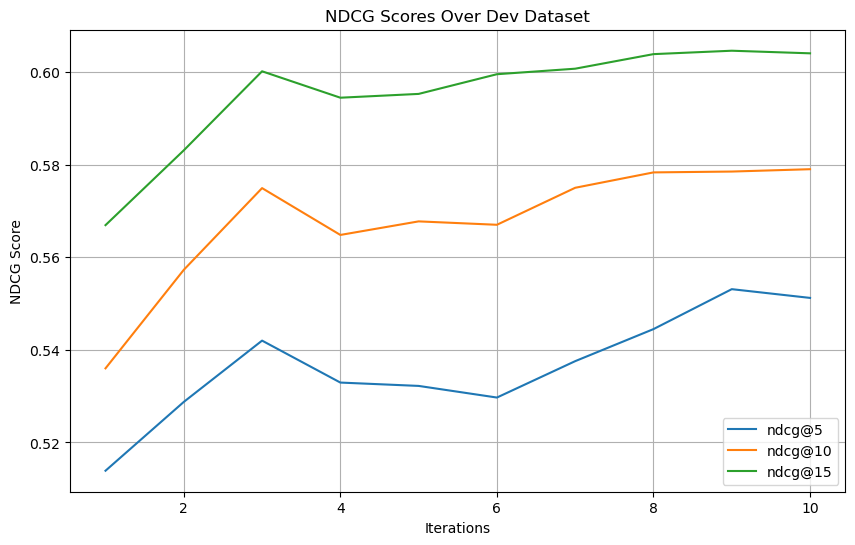

In [11]:
eval_results = l2r_ranker.model.model.evals_result_['valid_0']
iterations = range(1, len(eval_results['ndcg@5']) + 1)

plt.figure(figsize=(10, 6))
for key, values in eval_results.items():
    plt.plot(iterations, values, label=key)

plt.title('NDCG Scores Over Dev Dataset')
plt.xlabel('Iterations')
plt.ylabel('NDCG Score')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

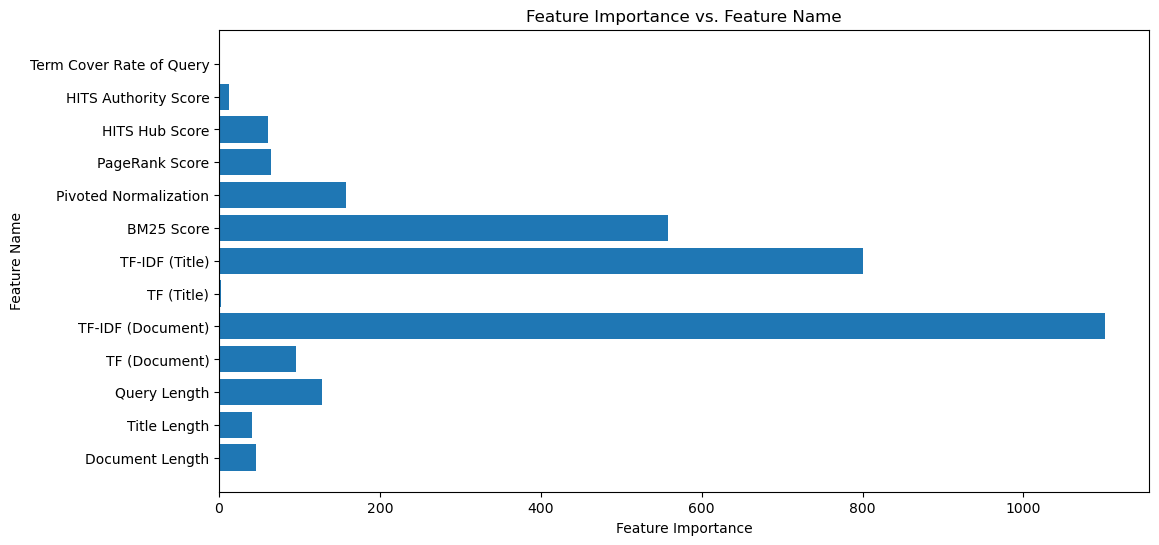

In [12]:
feature_import = list(l2r_ranker.model.model.feature_importances_ )
feature_name =[
    "Document Length",
    "Title Length",
    "Query Length",
    "TF (Document)",
    "TF-IDF (Document)",
    "TF (Title)",
    "TF-IDF (Title)",
    "BM25 Score",
    "Pivoted Normalization",
    "PageRank Score",
    "HITS Hub Score",
    "HITS Authority Score",
    "Term Cover Rate of Query"
]

# make a plot of feature importance vs. feature name
plt.figure(figsize=(12, 6))
plt.barh(feature_name, feature_import[:13])
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')  
plt.title('Feature Importance vs. Feature Name')
plt.show()

Among all features, BM25 score, TF-IDF of both title and document play the dominant role in ranking. Additionally added features like authority, hub, pagerank still partially contribute to the final performance, the reason could be that our l2r model can not fully learn from the train dataset.

#### Problem 6. (5 points)

Following up on the previous problem, which of the binary features
for the presence of top article categories were useful for ranking? (There were 118 of these
features.) Sort the categories by their feature importance scores and add a table with the
top 5 categories and their score. Which if any are useful when compared to the scores for
the non-category features?

In [13]:
cat_feature_import = feature_import[12:]
cat_idx_score = []
for i, score in enumerate(cat_feature_import):
    if score > 0:
        cat_idx_score.append((i, score))
cat_idx_score = sorted(cat_idx_score, key=lambda x: x[1], reverse=True)[:5]
cat_idx_score

[(6640, 50.92787003517151),
 (3847, 14.734800100326538),
 (2291, 14.399549961090088),
 (3140, 12.643919944763184),
 (3637, 10.46403980255127)]

In [14]:
cat_names = [l2r_feature_extractor.id_2_recognized_categories[i] for i, _ in cat_idx_score]
cat_names

['Category:Pages using multiple image with manual scaled images',
 'Category:Articles with failed verification from April 2019',
 'Category:All articles with peacock terms',
 'Category:Articles containing potentially dated statements from 2021',
 'Category:Articles with BNC identifiers']

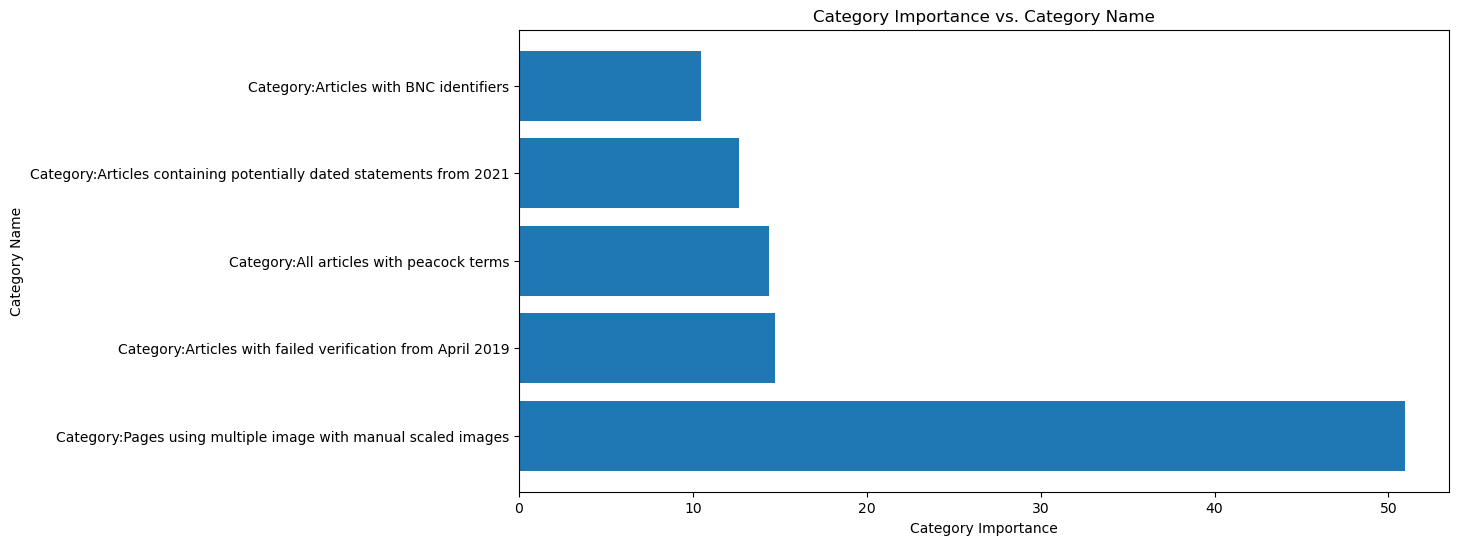

In [15]:
# make a plot of category importance vs. category name
plt.figure(figsize=(12, 6))
plt.barh(cat_names, [score for _, score in cat_idx_score])
plt.xlabel('Category Importance')
plt.ylabel('Category Name')
plt.title('Category Importance vs. Category Name')
plt.show()

The result is reasonable. Feature like `"Pages using multiple image with manual scaled images"` are most valued for ranking compared to hit authority score. These features identify the documents that are not rigourously verified, rated, formatted..., and pages that contain multiple manually scaled images might have been specifically curated for better visual representation, which could result to bad performance if recommended to the user.

#### Problem 7. (10 points)

Train the L2R system using all the features. Also, rank the
results using a BM25 ranker with the default hyperparameters. Score the predictions for
both models using the test set. We recommend training the L2R in code outside of the files
provided with the class, like in a Jupyter notebook. You can import the relevant classes and
train separately, which will make plotting a lot easier. Score your ranking function using
MAP@10 and NDCG@10. Plot the mean performance across all queries using a bar plot
using different bar colors for each of the models. If you use Seaborn, you can have it plot
the mean and show a 95% confidence interval, which is nice. In a few sentences, describe
what you see.

- Evaluate BM25 on test set 

In [24]:
relevance_path = './data/hw2_relevance.test.csv'
bm25 = BM25(doc_index)
bm25_ranker = Ranker(doc_index, RegexTokenizer('\w+'), stopwords_set, bm25)
bm25_relevance_test_res = relevance.run_relevance_tests(relevance_path, bm25_ranker)
bm25_relevance_test_res['map'], bm25_relevance_test_res['ndcg']

100%|██████████| 53/53 [00:00<00:00, 119.43it/s]


(0.0656371668164121, 0.19011657150103323)

- Evaluate BM25 on dev set 

In [17]:
# relevance_path = './data/hw2_relevance.dev.csv'
# bm25 = BM25(doc_index)
# bm25_ranker = Ranker(doc_index, RegexTokenizer('\w+'), stopwords_set, bm25)
# bm25_relevance_test_res = relevance.run_relevance_tests(relevance_path, bm25_ranker)
# bm25_relevance_test_res['map'], bm25_relevance_test_res['ndcg']

100%|██████████| 32/32 [00:00<00:00, 120.54it/s]


(0.08297619047619048, 0.2492185810657595)

- Evaluate l2r on test set 

In [18]:
relevance_path = './data/hw2_relevance.test.csv'
lgb_ranker = relevance.run_relevance_tests(relevance_path, l2r_ranker)
lgb_ranker['map'], lgb_ranker['ndcg']

100%|██████████| 53/53 [00:00<00:00, 112.27it/s]


(0.055982330038933825, 0.18089484346291293)

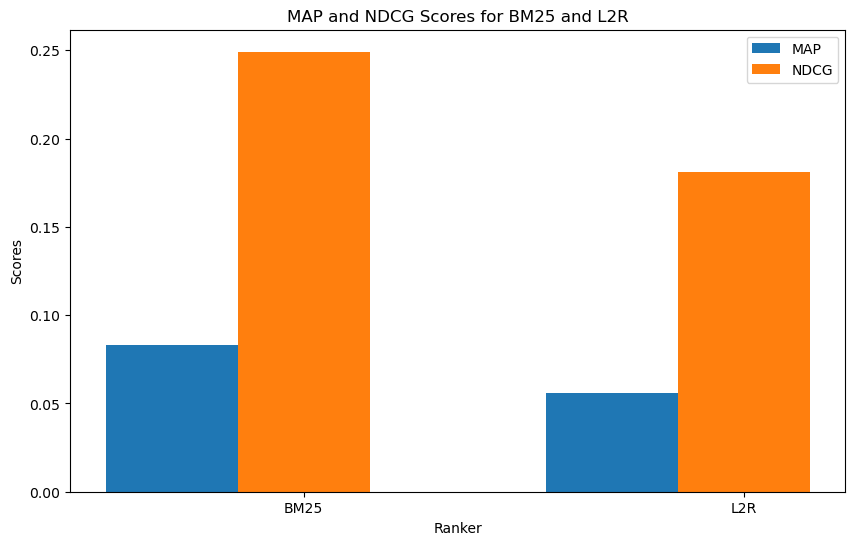

In [23]:
map_score = [bm25_relevance_test_res['map'], lgb_ranker['map']]
ndcg_score = [bm25_relevance_test_res['ndcg'], lgb_ranker['ndcg']]

# make a plot of MAP and NDCG scores for BM25 and L2R
plt.figure(figsize=(10, 6))
barWidth = 0.3
r1 = range(len(map_score))
r2 = [x + barWidth for x in r1]
plt.bar(r1, map_score, width=barWidth, label='MAP')
plt.bar(r2, ndcg_score, width=barWidth, label='NDCG')
plt.xlabel('Ranker')
plt.ylabel('Scores')
plt.xticks([r + barWidth for r in range(len(map_score))], ['BM25', 'L2R'])
plt.title('MAP and NDCG Scores for BM25 and L2R')
plt.legend()

plt.show()

The result shows that map@10 and ndcg@10 scores of l2r underperform ranking by BM25 only, the reason could be that the dataset is not representitve and the variation derived by different annotater could lead to potential bad performance and thus mislead the l2r model.